<a href="https://colab.research.google.com/github/dhruvang186/Big-data-Module-1/blob/main/Module_5_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import files
files.upload()

In [ ]:
bostonhousing = spark.read.csv('BostonHousing.csv',inferSchema=True, header=True)

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
bostonhousing.columns

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat',
 'medv']

In [ ]:
only_features= ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
assembler= VectorAssembler(inputCols=only_features,outputCol='features')

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
feat_df=assembler.transform(bostonhousing).select('features')

In [ ]:
scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(feat_df)
df_scaled=scaler.transform(feat_df)
df_scaled.show(5)

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
n_components=2
pca=PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('explained variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)    
     

explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
X_pca=df_pca.rdd.map(lambda row:row.pcafeatures).collect()
X_pca=np.array(X_pca)

In [ ]:
X_pca

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [ ]:
df_pca=pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


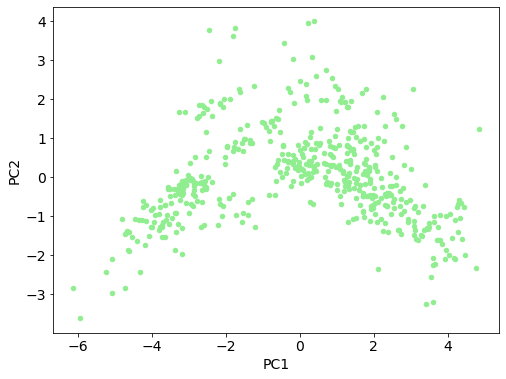

In [ ]:
plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=df_pca.plot.scatter(x='PC1',y='PC2',c='lightgreen')

In [ ]:
output=assembler.transform(bostonhousing)
f_data=output.select('features','medv')
f_data.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [ ]:
train_data,test_data= f_data.randomSplit([0.90,0.1])

In [ ]:
regressor=LinearRegression(featuresCol='features',labelCol='medv')
regressor=regressor.fit(train_data)

In [ ]:
coeff=regressor.coefficients
intr=regressor.intercept
print("The coefficient of the model is found to be:", coeff)
print("The intercept of the model is found to be:", intr)

print("The coefficient of the model is found to be: %a" %coeff)
print("The intercept of the model is found to be: %f" %intr)

The coefficient of the model is found to be: [-0.11194737195674388,0.057385754945201824,0.02792559928908975,2.5327475393059222,-19.889216594319663,3.3960019233998464,0.008308268987121236,-1.5090837487683029,0.319252404297704,-0.012594903893829024,-0.9164533503068358,0.008561705367515729,-0.5458296896130351]
The intercept of the model is found to be: 39.48215438682671
The coefficient of the model is found to be: DenseVector([-0.1119, 0.0574, 0.0279, 2.5327, -19.8892, 3.396, 0.0083, -1.5091, 0.3193, -0.0126, -0.9165, 0.0086, -0.5458])
The intercept of the model is found to be: 39.482154


In [ ]:
pred = regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01439,60.0,2.9...|29.1| 31.74682076678679|
|[0.03427,0.0,5.19...|19.5|20.113601184213024|
|[0.03548,80.0,3.6...|20.9|22.230022347831685|
|[0.03584,80.0,3.3...|23.5|30.905380009775584|
|[0.04294,28.0,15....|20.6|27.498799516554335|
+--------------------+----+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='medv',predictionCol='prediction',metricName='rmse')

rmse=eval.evaluate(pred.predictions)
print("RMSE : %.3f" %rmse)

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("MSE : %.3f" %mse)

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("MAE : %.3f" % mae)

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("r2 : %.3f" %r2)

RMSE : 4.189
MSE : 17.547
MAE : 2.979
r2 : 0.797
